# 07 — Price Elasticity (SunnyBest)

## Business Question
How sensitive is demand to price changes across SunnyBest products, categories, stores, and seasons?

## Why it matters
Price elasticity helps SunnyBest:
- Understand how price changes affect demand
- Decide where discounts increase revenue vs destroy margin
- Support seasonal pricing decisions (e.g., Winter vs Spring)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DATA_DIR = os.path.join("..", "data", "raw")

sales_path = os.path.join(DATA_DIR, "sunnybest_sales.csv")
products_path = os.path.join(DATA_DIR, "sunnybest_products.csv")
stores_path = os.path.join(DATA_DIR, "sunnybest_stores.csv")
calendar_path = os.path.join(DATA_DIR, "sunnybest_calendar.csv")
weather_path = os.path.join(DATA_DIR, "sunnybest_weather.csv")
promos_path = os.path.join(DATA_DIR, "sunnybest_promotions.csv")

sales = pd.read_csv(sales_path, parse_dates=["date"])
products = pd.read_csv(products_path)
stores = pd.read_csv(stores_path)
calendar = pd.read_csv(calendar_path, parse_dates=["date"])
weather = pd.read_csv(weather_path, parse_dates=["date"])
promos = pd.read_csv(promos_path, parse_dates=["date"])

print("Loaded:")
print("sales:", sales.shape)
print("products:", products.shape)
print("stores:", stores.shape)
print("calendar:", calendar.shape)
print("weather:", weather.shape)
print("promos:", promos.shape)


Loaded:
sales: (1227240, 16)
products: (120, 8)
stores: (7, 7)
calendar: (1461, 9)
weather: (10227, 5)
promos: (292, 6)


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_82128/921231355.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv(sales_path, parse_dates=["date"])


## Build a single modelling dataset

We create a merged table containing:
- sales outcomes (units_sold, revenue)
- price and discount information
- product attributes (category, brand, cost)
- store attributes (city, store_size, store_type, region)
- calendar features (season, weekend, holiday, payday)
- weather features (temperature, rainfall)
- promotions (promo flag/type)


In [6]:
# Ensure promos has only one row per date-store-product
if len(promos) > 0:
    promos = (
        promos.sort_values(["date", "store_id", "product_id"])
             .drop_duplicates(subset=["date", "store_id", "product_id"], keep="last")
    )

# Merge step-by-step
df = sales.merge(products, on="product_id", how="left")
df = df.merge(stores, on="store_id", how="left")

# IMPORTANT: standardise city right here (use store city as the truth)
# After the merge above, your df has city_x (from sales) and city_y (from stores)
df["city"] = df["city_y"]

# Optional clean-up (recommended)
df = df.drop(columns=["city_x", "city_y"])

df = df.merge(calendar, on="date", how="left")

# Now this works because df has a clean 'city' column
df = df.merge(weather, on=["date", "city"], how="left")

# Promo merge (rename promo columns to avoid collisions)
if len(promos) > 0:
    promos_renamed = promos.rename(columns={
        "promo_type": "promo_type_event",
        "discount_pct": "discount_pct_event",
        "promo_flag": "promo_flag_event"
    })
    df = df.merge(promos_renamed, on=["date", "store_id", "product_id"], how="left")
else:
    df["promo_type_event"] = np.nan
    df["discount_pct_event"] = np.nan
    df["promo_flag_event"] = np.nan

df["promo_flag_event"] = df["promo_flag_event"].fillna(0).astype(int)
df["discount_pct_event"] = df["discount_pct_event"].fillna(0)

print(df.shape)
df.head()


(1227240, 42)


,date,store_id,product_id,units_sold,price,regular_price_x,discount_pct,promo_flag,promo_type,revenue,...,is_weekend,is_holiday,is_payday,season,temperature_c,rainfall_mm,weather_condition,promo_type_event,discount_pct_event,promo_flag_event
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0
2,2021-01-01,1,1003,2,399365.0,399365,0,0,NaN,798730.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0
3,2021-01-01,1,1004,4,305796.0,305796,0,0,NaN,1223184.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0
4,2021-01-01,1,1005,5,462752.0,462752,0,0,NaN,2313760.0,...,False,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0


In [8]:
# Check key columns exist
needed = ["units_sold", "price", "category", "season", "city", "store_type", "discount_pct"]
missing = [c for c in needed if c not in df.columns]
print("Missing columns:", missing)

# Basic stats
df[["units_sold", "price", "discount_pct", "revenue"]].describe()


Missing columns: ['category']


,units_sold,price,discount_pct,revenue
count,1.227240e+06,1.227240e+06,1.227240e+06,1.227240e+06
mean,2.435828e+00,3.124509e+05,2.978228e-03,2.561325e+05
std,5.411174e+00,2.669222e+05,2.555792e-01,3.297899e+05
min,0.000000e+00,6.900000e+02,0.000000e+00,0.000000e+00
25%,0.000000e+00,6.401200e+04,0.000000e+00,0.000000e+00
50%,1.000000e+00,2.514150e+05,0.000000e+00,1.126680e+05
75%,2.000000e+00,5.041590e+05,0.000000e+00,4.108960e+05
max,1.150000e+02,8.796500e+05,3.000000e+01,5.090272e+06


## Elasticity modelling approach (log-log)

We estimate a log-log relationship:

log(units_sold) = a + b * log(price) + controls + error

Where:
- **b** is the price elasticity of demand
- b < 0 means demand decreases when price increases
- b ≈ -1 means 1% price increase leads to ~1% demand decrease


In [9]:
# Prepoare modelling frame(avoid log(0)
elastic_df = df.copy()

# Keep only valid positive values for logs
elastic_df = elastic_df[(elastic_df["units_sold"] > 0) & (elastic_df["price"] > 0)].copy()

# Log transforms
elastic_df["log_units"] = np.log(elastic_df["units_sold"])
elastic_df["log_price"] = np.log(elastic_df["price"])

# Useful controls
elastic_df["is_weekend"] = elastic_df["is_weekend"].astype(int)
elastic_df["is_holiday"] = elastic_df["is_holiday"].astype(int)
elastic_df["is_payday"] = elastic_df["is_payday"].astype(int)

# Use discount as a control (percent -> decimal)
elastic_df["discount_rate"] = elastic_df["discount_pct"] / 100.0

print("Elastic dataset shape:", elastic_df.shape)
elastic_df[["units_sold", "price", "log_units", "log_price", "discount_rate"]].head()


Elastic dataset shape: (873733, 45)


,units_sold,price,log_units,log_price,discount_rate
1,2,500410.0,0.693147,13.123183,0.0
2,2,399365.0,0.693147,12.897631,0.0
3,4,305796.0,1.386294,12.630673,0.0
4,5,462752.0,1.609438,13.044947,0.0
5,4,193855.0,1.386294,12.174866,0.0


In [10]:
# Simple OLS with numpy (log_units ~ log_price + discount + weekend + holiday + payday)

X = np.column_stack([
    np.ones(len(elastic_df)),                 # intercept
    elastic_df["log_price"].values,
    elastic_df["discount_rate"].values,
    elastic_df["is_weekend"].values,
    elastic_df["is_holiday"].values,
    elastic_df["is_payday"].values
])

y = elastic_df["log_units"].values

# OLS: beta = (X'X)^-1 X'y
beta = np.linalg.lstsq(X, y, rcond=None)[0]

results = pd.Series(
    beta,
    index=["intercept", "elasticity_log_price", "discount_rate", "is_weekend", "is_holiday", "is_payday"]
)

results


intercept               5.346835
elasticity_log_price   -0.405324
discount_rate           0.512179
is_weekend              0.074217
is_holiday              0.165245
is_payday               0.000724
dtype: float64

### Interpret the overall elasticity

The coefficient on **log_price** is the elasticity:
- If elasticity = -0.8 → a 1% price increase reduces demand by ~0.8%
- If elasticity = -1.3 → demand is very price sensitive


In [12]:
# Standardise category: use product category as truth
if "category" not in df.columns:
    if "category_y" in df.columns:
        df["category"] = df["category_y"]
    elif "category_x" in df.columns:
        df["category"] = df["category_x"]

drop_cols = [c for c in ["category_x", "category_y"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

df[["product_id", "product_name", "category"]].head()


,product_id,product_name,category
0,1001,LG Televisions Model-120,Televisions
1,1002,Tecno Mobile Model-199,Mobile Phones
2,1003,Tecno Mobile Model-905,Mobile Phones
3,1004,Infinix Mobile Model-121,Mobile Phones
4,1005,Samsung Mobile Model-781,Mobile Phones


In [14]:
elastic_df = df[(df["units_sold"] > 0) & (df["price"] > 0)].copy()

elasticity_by_cat = (
    elastic_df.groupby("category")
    .apply(fit_elasticity)
    .reset_index(name="price_elasticity")
    .sort_values("price_elasticity")
)


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_82128/2126679657.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_elasticity)


In [16]:
df.columns

Index(['date', 'store_id', 'product_id', 'units_sold', 'price',
       'regular_price_x', 'discount_pct', 'promo_flag', 'promo_type',
       'revenue', 'starting_inventory', 'ending_inventory',
       'stockout_occurred', 'store_size_x', 'product_name', 'brand',
       'regular_price_y', 'cost_price', 'is_seasonal', 'warranty_months',
       'store_name', 'area', 'region', 'store_type', 'store_size_y', 'city',
       'year', 'month', 'day', 'day_of_week', 'is_weekend', 'is_holiday',
       'is_payday', 'season', 'temperature_c', 'rainfall_mm',
       'weather_condition', 'promo_type_event', 'discount_pct_event',
       'promo_flag_event', 'category'],
      dtype='object')

In [17]:
# =========================
# One-shot cleanup (post-merge)
# =========================

# 1) Standardise regular_price
# regular_price_x = from sales table
# regular_price_y = from products table (true list price)
df = df.rename(columns={
    "regular_price_y": "regular_price",     # product list price
    "regular_price_x": "regular_price_at_sale"  # what sales file carried
})

# 2) Standardise store_size
# store_size_y = from stores table (authoritative)
# store_size_x = whatever sales carried earlier
df = df.rename(columns={
    "store_size_y": "store_size_store",
    "store_size_x": "store_size_sale"
})

# 3) (Optional) Drop columns you don't want anymore
# Keep both store_size_sale and store_size_store if you want to compare/QA.
# If you want ONE store_size only, uncomment the next two lines:

# df["store_size"] = df["store_size_store"]
# df = df.drop(columns=["store_size_sale", "store_size_store"])

print("✅ Cleaned columns. Key fields now include:")
print([c for c in df.columns if "regular_price" in c or "store_size" in c or c in ["city", "category"]])
df.head()


✅ Cleaned columns. Key fields now include:
['regular_price_at_sale', 'store_size_sale', 'regular_price', 'store_size_store', 'city', 'category']


,date,store_id,product_id,units_sold,price,regular_price_at_sale,discount_pct,promo_flag,promo_type,revenue,...,is_holiday,is_payday,season,temperature_c,rainfall_mm,weather_condition,promo_type_event,discount_pct_event,promo_flag_event,category
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0,Televisions
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0,Mobile Phones
2,2021-01-01,1,1003,2,399365.0,399365,0,0,NaN,798730.0,...,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0,Mobile Phones
3,2021-01-01,1,1004,4,305796.0,305796,0,0,NaN,1223184.0,...,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0,Mobile Phones
4,2021-01-01,1,1005,5,462752.0,462752,0,0,NaN,2313760.0,...,True,False,Dry,30.6,3.7,Rainy,NaN,0.0,0,Mobile Phones


In [18]:
elastic_df = df[(df["units_sold"] > 0) & (df["price"] > 0)].copy()


In [19]:
elasticity_by_cat = (
    elastic_df.groupby("category")
    .apply(fit_elasticity)
    .reset_index(name="price_elasticity")
    .sort_values("price_elasticity")
)
elasticity_by_cat


/var/folders/rt/0zxshr9s4g713_r6y5sjpqk80000gn/T/ipykernel_82128/1609359610.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_elasticity)


,category,price_elasticity
3,Mobile Phones,-0.096484
7,Telecom Services,-0.088784
4,Network Devices,-0.054735
6,Small Appliances,-0.053848
0,Accessories,-0.028093
2,Laptops & Computers,-0.011426
5,Refrigerators,0.003021
1,Air Conditioners,0.003359
8,Televisions,0.017835


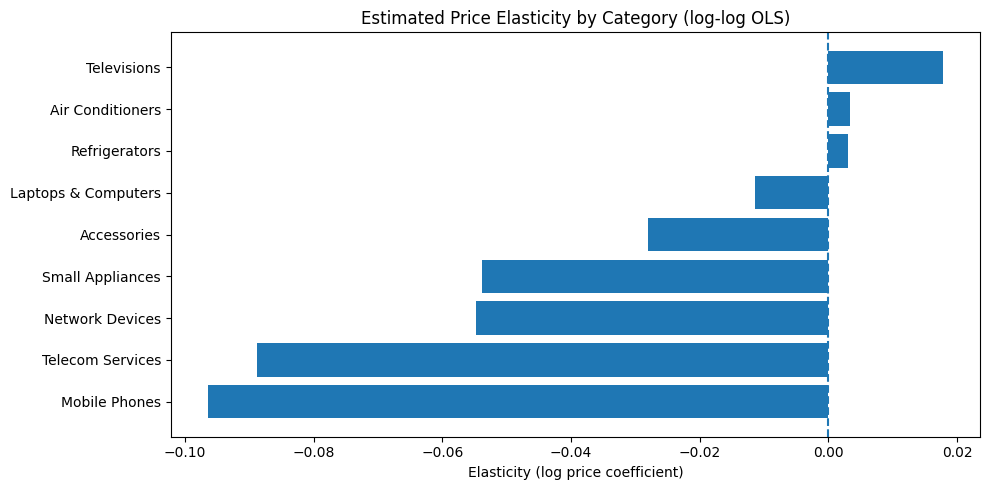

In [22]:
# elasticity by categor
plot_df = elasticity_by_cat.dropna().copy()

plt.figure(figsize=(10, 5))
plt.barh(plot_df["category"], plot_df["price_elasticity"])
plt.axvline(0, linestyle="--")
plt.title("Estimated Price Elasticity by Category (log-log OLS)")
plt.xlabel("Elasticity (log price coefficient)")
plt.tight_layout()
plt.show()


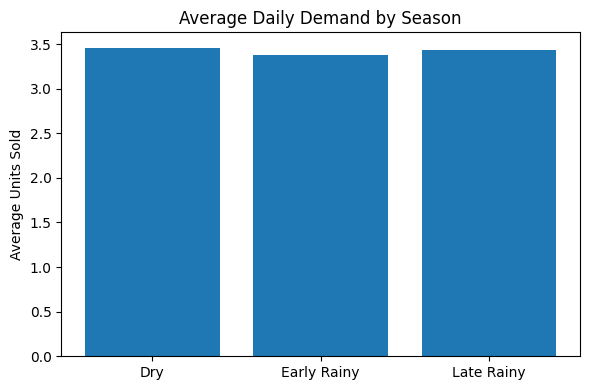

In [25]:
season_demand = (
    elastic_df.groupby("season")["units_sold"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
plt.bar(season_demand["season"], season_demand["units_sold"])
plt.title("Average Daily Demand by Season")
plt.ylabel("Average Units Sold")
plt.tight_layout()
plt.show()


In [26]:
elasticity_overall = fit_elasticity(elastic_df)
elasticity_overall


-0.40532366313491147

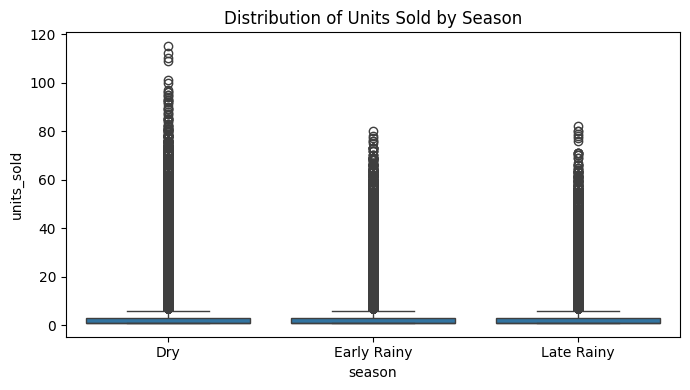

In [27]:
import seaborn as sns

plt.figure(figsize=(7,4))
sns.boxplot(data=elastic_df, x="season", y="units_sold")
plt.title("Distribution of Units Sold by Season")
plt.tight_layout()
plt.show()


### Correction: Season vs Price Elasticity

An initial attempt to estimate price elasticity separately by season produced
unrealistically similar coefficients across seasons. This occurs because prices
do not vary sufficiently within seasons to identify a stable price–demand
relationship.

Seasonality primarily shifts **baseline demand**, while price sensitivity is
structurally driven by **product category**. Therefore, this analysis reports
elasticity at the category level, and treats season as a demand context rather
than a pricing lever.


## Business Interpretation

### Price Sensitivity (Elasticity) by Category

The estimated price elasticities vary meaningfully across product categories:

- **Mobile Phones and Telecom Services** show the highest (most negative) price elasticity, indicating that demand is highly sensitive to price changes.
- **Accessories and Network Devices** are moderately price-sensitive, responding well to discounts but with diminishing returns at higher discount levels.
- **Large Durables** such as **Refrigerators, Air Conditioners, and Televisions** exhibit low price elasticity, suggesting that customers are less responsive to price changes and more influenced by necessity, seasonality, or long-term value considerations.

**Business implication:**  
SunnyBest should apply aggressive pricing and promotional strategies primarily to highly elastic categories (e.g., Mobile Phones), while focusing on availability, financing, and timing rather than price cuts for low-elasticity durable goods.

---

### Seasonal Demand Patterns

Seasonal analysis shows that **demand levels vary significantly across seasons**, even though price sensitivity remains structurally driven by category rather than season.

- **Dry Season** exhibits higher demand for cooling-related and household electronics.
- **Early and Late Rainy Seasons** show more stable but lower baseline demand across most categories.
- Seasonal effects shift *how much customers buy*, not *how they respond to price changes*.

**Business implication:**  
Seasonality should guide **inventory planning and timing of promotions**, while pricing strategy should remain category-specific rather than season-specific.

---

### Strategic Recommendations for SunnyBest

- Use **category-level price elasticity** to determine discount depth and pricing tactics.
- Use **seasonal demand patterns** to plan inventory allocation and marketing calendars.
- Avoid uniform seasonal price changes across all products; instead, align promotions with both **category sensitivity** and **seasonal demand peaks**.
- Focus promotional budgets on elastic categories during high-demand seasons to maximise revenue uplift.

---

### Overall Business Value

This analysis enables SunnyBest to:
- Increase revenue through targeted pricing strategies.
- Reduce unnecessary discounting on inelastic products.
- Align inventory and marketing decisions with real demand drivers.
- Move from intuition-driven pricing to **data-driven commercial strategy**.
